In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, spearmanr
from tqdm import tqdm

from alpha191 import Alphas191

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('tushare_data/raw_20180103_20230327.csv').iloc[:,1:]
df['date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
df = df.set_index(['date']).sort_values(by=['date'])
df = df.rename(columns={'vol': 'volume'})
df['log-ret'] = df.groupby('ts_code')['close'].pct_change()
df['vwap'] = df['amount']/df['volume']*10

In [3]:
#ts_code_list = ['000004.SZ','300391.SZ','600080.SH','600085.SH','000423.SZ','603538.SH']
ts_code_list = np.append(df.ts_code.unique()[:9],'603538.SH')
print(ts_code_list)
universe = df.loc[df.ts_code.isin(ts_code_list)].copy(deep=True)

['000004.SZ' '300391.SZ' '600080.SH' '600085.SH' '000423.SZ' '600129.SH'
 '600161.SH' '600196.SH' '600200.SH' '603538.SH']


## Define Benchmark

In [4]:
def benchmark_close_day(df):
    # calculate one day benchmark close values
    df['weights'] = df['total_mv'] / df['total_mv'].sum()
    return (df['weights'] * df['close']).sum()

def benchmark_open_day(df):
    # calculate one day benchmark close values
    df['weights'] = df['total_mv'] / df['total_mv'].sum()
    return (df['weights'] * df['open']).sum()

benchmark_close = universe.groupby('trade_date').apply(benchmark_close_day)
benchmark_open = universe.groupby('trade_date').apply(benchmark_open_day)

## Alpha 191

Common Functions

In [60]:
from scipy.stats import rankdata

## calculate correlation bettwen two series in a rolling period time
def Corr(data, win_len):
    obj = data.rolling(window=win_len, method='table')
    s = []
    for o in obj:
        if o.shape[0] < win_len:
            s.append(0.)
        else:
            s.append(spearmanr(o.iloc[:,0], o.iloc[:,1])[0])
            #s.append(o.iloc[:, 0].corr(o.iloc[:, 1]))
    return pd.DataFrame(s, index=data.index, columns=['corr'])

## calculate series rank in a rolling period time and get last time rank value
def Tsrank(sr, window):
    return sr.rolling(window).apply(lambda x: rankdata(x)[-1])

def Sma(sr, n, m):
    return sr.ewm(alpha=m / n, adjust=False).mean()

def Sequence(n):
    # 生成 1~n 的等差序列
    return np.arange(1, n + 1)


def Regbeta(sr, x):
    window = len(x)
    return sr.rolling(window).apply(lambda y: np.polyfit(x, y, deg=1)[0])

Alpha factors calculate

In [76]:
## need nothing (good)
def alpha001(df):
    ## 成交量 与 涨幅关系 （提高换手率）
    ##### (-1 * CORR(RANK(DELTA(LOG(VOLUME), 1)), RANK(((CLOSE - OPEN) / OPEN)), 6))####
    df['section1'] = np.log(df['volume'])
    ##====improve====
    #df['section1'] = df['volume']/df['total_share']
    df['section1'] = df.groupby('ts_code')['section1'].diff(1)
    df['section2'] = ((df.close - df.open) / df.open)
    df[['section1','section2']] = df.groupby('trade_date')[['section1','section2']].rank(method='min', pct=True)
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='alpha001 processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp['alpha_001'] = -Corr(tmp[['section1','section2']], 6)['corr']
        df_all = df_all.append(tmp)
    df_all = df_all.drop(columns=['section1','section2']).sort_values(by=['date'])
    return df_all

## need zscore and percent (test)
def alpha002(df):
    ## K线形态变化
    ##### -1 * delta((((close-low)-(high-close))/(high-low)),1))####
    df['alpha_002'] = -(((df.close - df.low) - (df.high - df.close)) / (df.high - df.low)).diff(1) 
    return df

## need zscore and percent (good)
def alpha003(all_df):
    ## 累计阶段涨跌趋势
    ##### SUM((CLOSE=DELAY(CLOSE,1)?0:CLOSE-(CLOSE>DELAY(CLOSE,1)?MIN(LOW,DELAY(CLOSE,1)):MAX(HIGH,DELAY(CLOSE,1)))),6) ####
    def cal_by_ticker(df):
        cond1 = (df.close == df.close.shift(1).fillna(method='ffill'))
        cond2 = (df.close > df.close.shift(1).fillna(method='ffill'))
        cond3 = (df.close < df.close.shift(1).fillna(method='ffill'))
        part = df.close.copy(deep=True)
        part[cond1] = 0
        part[cond2] = df.close - np.minimum(df.low, df.close.shift(1).fillna(method='ffill'))
        part[cond3] = df.close - np.maximum(df.high, df.close.shift(1).fillna(method='ffill'))
        df['alpha_003'] = part.rolling(window=6).sum()
        ## ===improve===
        df['alpha_003'] = df['alpha_003']/df['close']
        return df
    return all_df.groupby('ts_code').apply(cal_by_ticker)

## need zscore and percent (no)
def alpha004(df_all):
    ## 短期突破类似cci
    #####((((SUM(CLOSE, 8) / 8) + STD(CLOSE, 8)) < (SUM(CLOSE, 2) / 2)) ? (-1 * 1) : (((SUM(CLOSE, 2) / 2) <((SUM(CLOSE, 8) / 8) - STD(CLOSE, 8))) ? 1 : (((1 < (VOLUME / MEAN(VOLUME,20))) || ((VOLUME /MEAN(VOLUME,20)) == 1)) ? 1 : (-1 * 1))))
    def cal_(df):
        cond_L = df['close'].rolling(window=8).apply(lambda x:x.mean()+x.std())
        cond_R = df['close'].rolling(window=2).mean()
        cond1 = cond_L < cond_R
        cond2 = cond_L > cond_R
        cond3 = cond_L == cond_R
        cond4 = (df['volume'] / df['volume'].rolling(window=20).mean()) >= 1
        part = df.close.copy(deep=True)
        part[cond1] = -1
        part[cond2] = 1
        part[cond3] = -1
        part[cond3 & cond4] = 1
        df['alpha_004'] = part
        ## ===improve===
        df['alpha_004'] = df['alpha_004']/df['close']
        return df
    
    return df_all.groupby('ts_code').apply(cal_)

## need nothing (test)
def alpha005(df):  # 1447
    ## 5日最大价量相关系数
    ####(-1 * TSMAX(CORR(TSRANK(VOLUME, 5), TSRANK(HIGH, 5), 5), 3))###
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='alpha005 processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp['Tsrank_v'] = Tsrank(tmp.volume, 5)
        tmp['Tsrank_h'] = Tsrank(tmp.high, 5)
        tmp['alpha_005'] = Corr(tmp[['Tsrank_v', 'Tsrank_h']], 5)['corr']
        tmp['alpha_005'] = -tmp['alpha_005'].rolling(window=3).max()
        df_all = df_all.append(tmp)
    df_all['alpha_005'].fillna(0., inplace=True)
    df_all = df_all.drop(columns=['Tsrank_v','Tsrank_h']).sort_values(by=['date'])
    return df_all

## need zscore and percent (test)
def alpha006(df_all):  # 1779
    ## 开盘半小时寻找买卖点
    ####(RANK(SIGN(DELTA((((OPEN * 0.85) + (HIGH * 0.15))), 4)))* -1)###
    def cal_(df):
        df['alpha_006'] = -np.sign(((df.open * 0.85) + (df.high * 0.15)).diff(4).fillna(0.))
        return df
    df_all = df_all.groupby('ts_code').apply(cal_)
    df_all['alpha_006'] = df_all.groupby('trade_date')['alpha_006'].rank(method='min', pct=True)
    return df_all

## need nothing (good)
def alpha007(df): 
    ## 横截面价量操作方式（具备买卖方向）
    ####((RANK(MAX((VWAP - CLOSE), 3)) + RANK(MIN((VWAP - CLOSE), 3))) * RANK(DELTA(VOLUME, 3)))###
    def cal_(df):
        rolling_obj = (df['vwap'] - df['close']).rolling(3)
        df['section1'] = rolling_obj.max()
        df['section2'] = rolling_obj.min()
        df['section3'] = df['volume'].diff(3)
        return df
    
    df_all = df.groupby('ts_code').apply(cal_)
    df_all[['section1','section2','section3']] = df_all.groupby('trade_date')[['section1','section2','section3']]\
                                                .rank(method='min', pct=True)
    df_all['alpha_007'] = (df_all['section1'] + df_all['section2']) * df_all['section3']
    df_all = df_all.drop(columns=['section1','section2','section3'])
    return df_all

# need nothing (test)
def alpha008(df):
    ## 4日价差突破波动逆转
    ####RANK(DELTA(((((HIGH + LOW) / 2) * 0.2) + (VWAP * 0.8)), 4) * -1)###
    #df['alpha_008'] = ((df['high'] + df['low']) * 0.2 + df['vwap'] * 0.8)
    ### ====improve====
    df['alpha_008'] = ((df['high'] + df['low']) * 0.2 + df['vwap'] * 0.8)
    df['alpha_008'] = - df.groupby('ts_code')['alpha_008'].diff(4)
    df['alpha_008'] = df.groupby('trade_date')['alpha_008'].rank(method='min', pct=True)
    return df

# need percent (test)
def alpha009(df):
    ## 价量背离（钝化）
    ####SMA(((HIGH+LOW)/2-(DELAY(HIGH,1)+DELAY(LOW,1))/2)*(HIGH-LOW)/VOLUME,7,2)###
    def cal_(df):
        term = ((df.high + df.low) / 2 - (df.high.diff(1) + df.low.diff(1)) / 2) * (df.high - df.low) / df.volume
        df['alpha_009'] = Sma(term, 7, 2)
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    return df

# need percent (good)
def alpha010(df):
    ## 横截面相对价格突破
    ####(RANK(MAX(((RET < 0) ? STD(RET, 20) : CLOSE)^2),5))###
    def cal_(df):
        df['alpha_010'] = np.where(df['log-ret'] < 0, df['log-ret'].rolling(20).std(), df['close'])
        df['alpha_010'] = (df['alpha_010'] ** 2).rolling(window=5).max()
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    df['alpha_010'] = df.groupby('trade_date')['alpha_010'].rank(method='min', pct=True)

    return df

# need percent (no)
def alpha011(df): 
    # 价量背离（原始简易构造）
    ####SUM(((CLOSE-LOW)-(HIGH-CLOSE))/(HIGH-LOW)*VOLUME,6)###
    def cal_(df):
        df['alpha_011'] = ((df.close - df.low)*1000/((df.high - df.low) * df.volume)).rolling(6).sum()
        return df
    df = df.groupby('ts_code').apply(cal_)
    return df

# need add offset (test)
def alpha012(df): 
    # 大幅低开
    ####(RANK((OPEN - (SUM(VWAP, 10) / 10)))) * (-1 * (RANK(ABS((CLOSE - VWAP)))))###
    def cal_(df):
        df['section1'] = df.open - df.vwap.rolling(window=10).mean()
        df['section2'] = (df.close - df.vwap).abs()
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    df[['section1','section2']] = df.groupby('trade_date')[['section1','section2']].rank(method='min', pct=True)
    df['alpha_012'] = df['section1'] * (-df['section2'])
    df.drop(columns=['section1', 'section2'], inplace=True)
    return df

# need zscore and percent(no)
def alpha013(df):
    ## 感觉没什么用
    ####(((HIGH * LOW)^0.5) - VWAP)###
    ## ===improve====
    df['alpha_013'] = (((df.high * df.low) ** 0.5) - df.vwap)/df.vwap
    return df

# need zscore and percent (no)
def alpha014(df):
    ## 动量预判
    ####CLOSE-DELAY(CLOSE,5)###
    def cal_(df):
        ## ==== improve ====
        df['alpha_014'] = (df['close'] - df['close'].diff(5))/df['close']
        return df
    df = df.groupby('ts_code').apply(cal_)
    return df

# need percent (no)
def alpha015(df):
    ## 隔夜收益率
    ####OPEN/DELAY(CLOSE,1)-1###
    def cal_(df):
        df['alpha_015'] = (df['open'] - df['close'].shift(1).fillna(method='ffill'))/df['open']
        return df
    df = df.groupby('ts_code').apply(cal_)
    return df

# need nothing (good)
def alpha016(df):
    ## 5日横截面最大价量负相关
    ####(-1 * TSMAX(RANK(CORR(RANK(VOLUME), RANK(VWAP), 5)), 5))###
    df[['section1','section2']] = df.groupby('trade_date')[['volume','vwap']].apply(zscore)
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='alpha016 processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp['alpha_016'] = Corr(tmp[['section1','section2']], 6)['corr']
        df_all = df_all.append(tmp)
    
    def cal_(df):
        df['alpha_016'] = -df['alpha_016'].rolling(5).max()
        df['alpha_016'] = df['alpha_016'] + 1.
        return df
        
    df_all['alpha_016'] = df_all.groupby('trade_date')['alpha_016'].rank(method='min', pct=True)
    df_all = df_all.groupby('ts_code').apply(cal_)
    df_all.drop(columns=['section1','section2'], inplace=True)
    return df_all

# need zscore and percent (test)
def alpha017(df):
    ## 15日以来的最新上涨动力
    ####RANK((VWAP - MAX(VWAP, 15)))^DELTA(CLOSE, 5)###
    def cal1_(df):
        #df['alpha_017'] = df['vwap'] - df['vwap'].rolling(window=15).max()
        # ==== improve ====
        df['alpha_017'] = (df['vwap'] - df['vwap'].rolling(window=15).max())/df['vwap']
        return df
    
    def cal2_(df):
        #df['alpha_017'] = df['alpha_017'] ** df['close'].diff(5).fillna(0.)
        # ====improve====
        df['alpha_017'] = df['alpha_017'] ** (df['close'].diff(5).fillna(0.)/df['close'])
        return df
    
    df = df.groupby('ts_code').apply(cal1_)
    df['alpha_017'] = df.groupby('trade_date')['alpha_017'].rank(method='min', pct=True)
    df = df.groupby('ts_code').apply(cal2_)
    return df

# need nothing (no)
def alpha018(df):
    # 5日涨跌动力 （简易）
    ####CLOSE/DELAY(CLOSE,5)###
    def cal_(df):
        #df['alpha_018'] = df['close'] / df['close'].shift(5)
        # ==== improve ====
        df['alpha_018'] = -df['close'] / df['close'].shift(5)
        return df
    df = df.groupby('ts_code').apply(cal_)
    # ==== improve ====
    df['alpha_018'] = df.groupby('trade_date')['alpha_018'].rank(method='min', pct=True)
    return df

# need percent (good)
def alpha019(df):
    # 5日涨跌动力 (归一化)
    ####(CLOSE<DELAY(CLOSE,5)?(CLOSE-DELAY(CLOSE,5))/DELAY(CLOSE,5):(CLOSE=DELAY(CLOSE,5)?0:(CLOSE-DELAY(CLOSE,5))/CLOSE))###
    def cal_(df):
        df['alpha_019'] = np.where(df['close']<df['close'].shift(5), 
                                 (df['close'] - df['close'].shift(5))/df['close'].shift(5),
                                 np.where(df['close']>df['close'].shift(5),
                                        (df['close'] - df['close'].shift(5))/df['close'], 0.))
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    return df

# need nothing (test)
def alpha020(df): 
    ####(CLOSE-DELAY(CLOSE,6))/DELAY(CLOSE,6)*100###
    # 6日涨跌动力 （简易）
    ####CLOSE/DELAY(CLOSE,5)###
    def cal_(df):
        df['alpha_020'] = (df['close'] - df['close'].shift(6))/df['close'].shift(6)
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    
    return df

# need percent (good)
def alpha021(df):
    # 6日close均值~时间窗口回归
    ####REGBETA(MEAN(CLOSE,6),SEQUENCE(6))###
    def cal_(df):
        df['alpha_021'] = Regbeta(df['close'].rolling(6).mean(), Sequence(6))
        return df
        
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(),desc='alpha021 processing...'):
        tmp = df.loc[df.ts_code==ts_code]
        tmp = cal_(tmp)
        df_all = df_all.append(tmp)
        
    return df_all

# need percent (good)
def alpha022(df):
    ## 6日收益均值趋势 12日sma平滑处理
    ####SMA(((CLOSE-MEAN(CLOSE,6))/MEAN(CLOSE,6)-DELAY((CLOSE-MEAN(CLOSE,6))/MEAN(CLOSE,6),3)),12,1)###
    def cal_(df):
        section1 = (df['close'] - df['close'].rolling(window=6).mean())/df['close'].rolling(window=6).mean()
        section2 = section1.shift(3)
        df['alpha_022'] = Sma((section1 - section2), 12, 1)
        return df
    
    df = df.groupby('ts_code').apply(cal_)
    return df

## percent
def alpha023(df):
    ## 20日上涨波动大小与收益正相关
    ####SMA((CLOSE>DELAY(CLOSE,1)?STD(CLOSE,20):0),20,1) / (SMA((CLOSE>DELAY(CLOSE,1)?STD(CLOSE,20):0),20,1) + SMA((CLOSE<=DELAY(CLOSE,1)?STD(CLOSE,20):0),20,1))*100###
    def cal_(df):
        cond = df['close'] > df['close'].shift(1)
        part1 = df.close.copy(deep=True)
        part1[cond] = df['close'].rolling(window=20).std()
        part1[~cond] = 0
        part2 = df.close.copy(deep=True)
        part2[~cond] = df['close'].rolling(window=20).std()
        part2[cond] = 0
        df['alpha_023'] = 100 * Sma(part1, 20, 1) / (Sma(part1, 20, 1) + Sma(part2, 20, 1))
        return df
    df = df.groupby('ts_code').apply(cal_)
    return df

# universe = alpha001(universe)
# universe = alpha002(universe)
# universe = alpha003(universe)
# universe = alpha004(universe)
# universe = alpha005(universe)
# universe = alpha006(universe)
# universe = alpha007(universe)
# universe = alpha008(universe)
# universe = alpha009(universe)
# universe = alpha010(universe)
# universe = alpha011(universe)
# universe = alpha012(universe)
# universe = alpha013(universe)
# universe = alpha014(universe)
# universe = alpha015(universe)
# universe = alpha016(universe)
# universe = alpha017(universe)
# universe = alpha018(universe)
# universe = alpha019(universe)
# universe = alpha020(universe)
# universe = alpha021(universe)
# universe = alpha022(universe)
universe = alpha023(universe)

In [77]:
print(universe.ts_code.unique())
universe.tail()

['000004.SZ' '000423.SZ' '300391.SZ' '600080.SH' '600085.SH' '600129.SH'
 '600161.SH' '600196.SH' '600200.SH' '603538.SH']


,ts_code,trade_date,turnover_rate,pe,pb,total_share,free_share,total_mv,circ_mv,name,...,log-ret,vwap,alpha_016,alpha_017,alpha_018,alpa_019,alpha_020,alpha_021,alpha_022,alpha_023
date,,,,,,,,,,,,,,,,,,,,,
2019-04-04,603538.SH,20190404,3.3151,69.3974,2.6792,14913.4000,8034.9261,310049.5860,185987.3400,美诺华,...,0.005319,20.652848,0.444444,0.958207,0.555556,0.072631,0.053191,0.347492,0.007853,49.144050
2019-04-08,603538.SH,20190408,5.1344,70.7994,2.7333,14913.4000,8034.9261,316313.2140,189744.6600,美诺华,...,0.020202,21.164827,0.333333,0.944625,0.222222,0.070250,0.100103,0.284314,0.007753,50.276588
2019-04-09,603538.SH,20190409,12.5121,77.8760,3.0065,14913.4000,8034.9261,347929.6220,208710.1800,美诺华,...,0.099953,22.597428,0.111111,0.926269,0.222222,0.130304,0.183063,0.252106,0.013088,51.581608
2019-11-06,603538.SH,20191106,6.7460,37.7509,2.7986,14968.2000,8333.8461,363727.2600,222294.4560,美诺华,...,0.000823,24.225480,0.000000,0.979994,0.222222,0.171577,0.209492,0.277185,0.019904,53.071037
2022-05-05,603538.SH,20220505,9.2207,50.2687,3.8854,15243.8619,10965.4859,716461.5093,708340.5673,美诺华,...,0.028672,46.008651,0.000000,0.795137,0.111111,0.565379,1.340467,0.748888,0.082489,56.657507


<AxesSubplot:title={'center':'alpha_023'}, xlabel='date'>

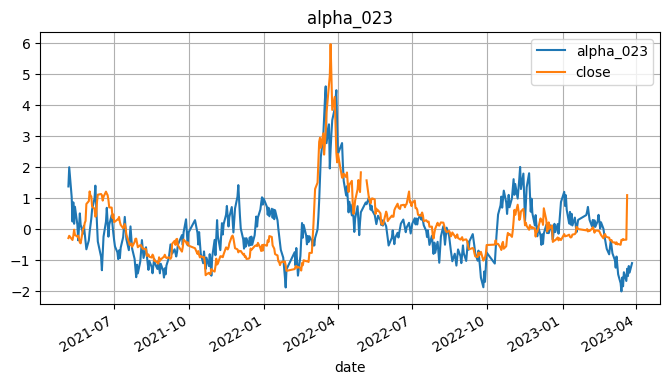

In [79]:
### benchmark_close.plot()
#benchmark_open.plot()
name = 'alpha_023'
tmp = universe.loc[(universe.ts_code=='603538.SH') & (universe['trade_date']>20210501)][[name,'close']]
tmp[['close',name]] = tmp[['close', name]].apply(zscore)
#tmp[['close']] = tmp[['close']].apply(zscore)
tmp['close'] = tmp['close'].shift(-5)
#tmp['log-ret'] = tmp['log-ret'].shift(-5)
#tmp[name] = tmp[name]-0.7
tmp.plot(title=name, grid=True)
#tmp['close'].rank(method='min', pct=True).plot()

In [ ]:
#universe.loc[universe.ts_code=='603538.SH'][['amount','volume','vwap']]
universe.loc[universe.ts_code=='603538.SH'][['close','volume']]

<AxesSubplot:>

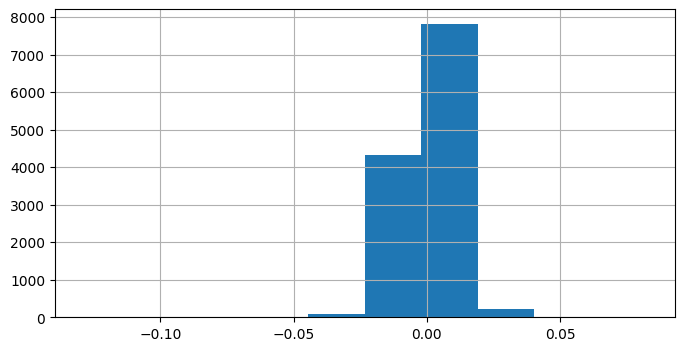

In [73]:
universe.alpha_022.hist()